<a href="https://colab.research.google.com/github/joomj2000/OpenCV/blob/main/%E1%84%8B%E1%85%B5%E1%84%86%E1%85%B5%E1%84%8C%E1%85%B5%E1%84%87%E1%85%AE%E1%86%AB%E1%84%92%E1%85%A1%E1%86%AF_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 데이터 처리 및 분석을 위한 기본 라이브러리
import numpy as np
import pandas as pd

# 데이터 시각화 도구
import matplotlib.pyplot as plt
import seaborn as sns

# 이미지 처리 관련 라이브러리
from PIL import Image
from glob import glob

# 진행 상태를 추적하는 데 도움이 되는 라이브러리
from tqdm import tqdm

# 딥러닝 모델링을 위한 TensorFlow 및 관련 콜백
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# 다운로드가 안 될 경우 아래 명령어의 주석을 해제하고 실행한 후 다시 시도해보세요.
# !pip install --upgrade --no-cache-dir gdown

In [3]:
!gdown 12SmqZSWY8IGyPvCgdgpR7SXUQzSunCDE
!unzip cityscapes.zip

Downloading...
From (original): https://drive.google.com/uc?id=12SmqZSWY8IGyPvCgdgpR7SXUQzSunCDE
From (redirected): https://drive.google.com/uc?id=12SmqZSWY8IGyPvCgdgpR7SXUQzSunCDE&confirm=t&uuid=fbb1dd2a-ea28-4434-98a3-d2664adc93c7
To: /content/cityscapes.zip
100% 106M/106M [00:01<00:00, 77.2MB/s] 
Archive:  cityscapes.zip
  inflating: cityscapes/desktop.ini  
   creating: cityscapes/train/
  inflating: cityscapes/train/1.jpg  
  inflating: cityscapes/train/10.jpg  
  inflating: cityscapes/train/100.jpg  
  inflating: cityscapes/train/1000.jpg  
  inflating: cityscapes/train/1001.jpg  
  inflating: cityscapes/train/1002.jpg  
  inflating: cityscapes/train/1003.jpg  
  inflating: cityscapes/train/1004.jpg  
  inflating: cityscapes/train/1005.jpg  
  inflating: cityscapes/train/1006.jpg  
  inflating: cityscapes/train/1007.jpg  
  inflating: cityscapes/train/1008.jpg  
  inflating: cityscapes/train/1009.jpg  
  inflating: cityscapes/train/101.jpg  
  inflating: cityscapes/train/1010.jpg

In [4]:
import os

def get_image_paths(directory):
    return glob(os.path.join(directory, '*.jpg'))

train_dir = 'cityscapes/train/'
val_dir = 'cityscapes/val/'

train_image_paths = get_image_paths(train_dir)
val_image_paths = get_image_paths(val_dir)

print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of validation images: {len(val_image_paths)}")

Number of training images: 2975
Number of validation images: 500


In [5]:
from collections import namedtuple
Label = namedtuple( 'Label' , ['name', 'id' ,'trainId','category','categoryId','hasInstances','ignoreInEval','color'] )

# Semantic Segmentation 작업에서 사용되는 데이터셋의 레이블 정보를 정의

labels=[
Label('unlabeled',0,255,'void',0,False,True,(0,0,0)),
Label('egovehicle',1,255,'void',0,False,True,(0,0,0)),
Label('rectificationborder',2,255,'void',0,False,True,(0,0,0)),
Label('outofroi',3,255,'void',0,False,True,(0,0,0)),
Label('static',4,255,'void',0,False,True,(0,0,0)),
Label('dynamic',5,255,'void',0,False,True,(111,74,0)),
Label('ground',6,255,'void',0,False,True,(81,0,81)),
Label('road',7,0,'ground',1,False,False,(128,64,128)),
Label('sidewalk',8,1,'ground',1,False,False,(244,35,232)),
Label('parking',9,255,'ground',1,False,True,(250,170,160)),
Label('railtrack',10,255,'ground',1,False,True,(230,150,140)),
Label('building',11,2,'construction',2,False,False,(70,70,70)),
Label('wall',12,3,'construction',2,False,False,(102,102,156)),
Label('fence',13,4,'construction',2,False,False,(190,153,153)),
Label('guardrail',14,255,'construction',2,False,True,(180,165,180)),
Label('bridge',15,255,'construction',2,False,True,(150,100,100)),
Label('tunnel',16,255,'construction',2,False,True,(150,120,90)),
Label('pole',17,5,'object',3,False,False,(153,153,153)),
Label('polegroup',18,255,'object',3,False,True,(153,153,153)),
Label('trafficlight',19,6,'object',3,False,False,(250,170,30)),
Label('trafficsign',20,7,'object',3,False,False,(220,220,0)),
Label('vegetation',21,8,'nature',4,False,False,(107,142,35)),
Label('terrain',22,9,'nature',4,False,False,(152,251,152)),
Label('sky',23,10,'sky',5,False,False,(70,130,180)),
Label('person',24,11,'human',6,True,False,(220,20,60)),
Label('rider',25,12,'human',6,True,False,(255,0,0)),
Label('car',26,13,'vehicle',7,True,False,(0,0,142)),
Label('truck',27,14,'vehicle',7,True,False,(0,0,70)),
Label('bus',28,15,'vehicle',7,True,False,(0,60,100)),
Label('caravan',29,255,'vehicle',7,True,True,(0,0,90)),
Label('trailer',30,255,'vehicle',7,True,True,(0,0,110)),
Label('train',31,16,'vehicle',7,True,False,(0,80,100)),
Label('motorcycle',32,17,'vehicle',7,True,False,(0,0,230)),
Label('bicycle',33,18,'vehicle',7,True,False,(119,11,32)),
Label('licenseplate',34,19,'vehicle',7,False,True,(0,0,142)),
]

In [6]:
N_FILTERS = 64
KERNEL_SIZE = 3
N_CLASSES = len(labels)
IMAGE_SIZE = 128
EPOCHS = 15
BATCH_SIZE = 16

MODEL_CHECKPOINT_FILEPATH = './cityscapes-unet.ckpt'

id2color = { label.id : np.asarray(label.color) for label in labels }

In [7]:
def image_mask_split(filename, image_size): # 이미지 파일에서 이미지와 마스크를 분리하고, 이들을 지정된 크기로 리사이즈한 후 반환
    image_mask = Image.open(filename)

    # 원본 이미지에서 좌상단 [0, 0]에서 우하단 [256, 256]까지의 영역을 잘라서 image로 사용
    # image_mask.crop([256, 0, 512, 256]): 원본 이미지에서 좌상단 [256, 0]에서 우하단 [512, 256]까지의 영역을 잘라서 mask로 사용

    image, mask = image_mask.crop([0, 0, 256, 256]), image_mask.crop([256, 0, 512, 256])
    image = image.resize((image_size, image_size))
    mask = mask.resize((image_size, image_size))
    image = np.array(image) / 255
    mask = np.array(mask)

    return image, mask

def find_closest_labels_vectorized(mask, mapping): # 셀의 색상과 가장 가까운 레이블을 찾기 위해 벡터화된 연산을 사용 / 마스크를 레이블 카테고리로 변환
    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000)
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)
    for id, color in mapping.items():
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category)
    return closest_category

In [8]:
# 훈련 및 검증 데이터셋 준비

train_images = []
train_masks = []
train_masks_enc = []
val_images = []
val_masks = []
val_masks_enc = []

train_lists = glob(f'{train_dir}*.jpg')
val_lists = glob(f'{val_dir}*.jpg')
print(len(train_lists), len(val_lists))

for train_file in tqdm(train_lists, desc = 'Building Training Dataset: '): # 훈련 이미지 파일을 순회하며 데이터를 처리
    image, mask = image_mask_split(train_file, IMAGE_SIZE)
    train_images.append(image)
    train_masks.append(mask)
    train_masks_enc.append(find_closest_labels_vectorized(mask, id2color)) #마스크의 각 픽셀에 대해 가장 가까운 레이블 ID를 찾

for val_file in tqdm(val_lists, desc = 'Building Validation Dataset: '):
    image, mask = image_mask_split(val_file, IMAGE_SIZE)
    val_images.append(image)
    val_masks.append(mask)
    val_masks_enc.append(find_closest_labels_vectorized(mask, id2color))

2975 500


Building Validation Dataset: 100%|██████████| 500/500 [00:18<00:00, 26.96it/s]


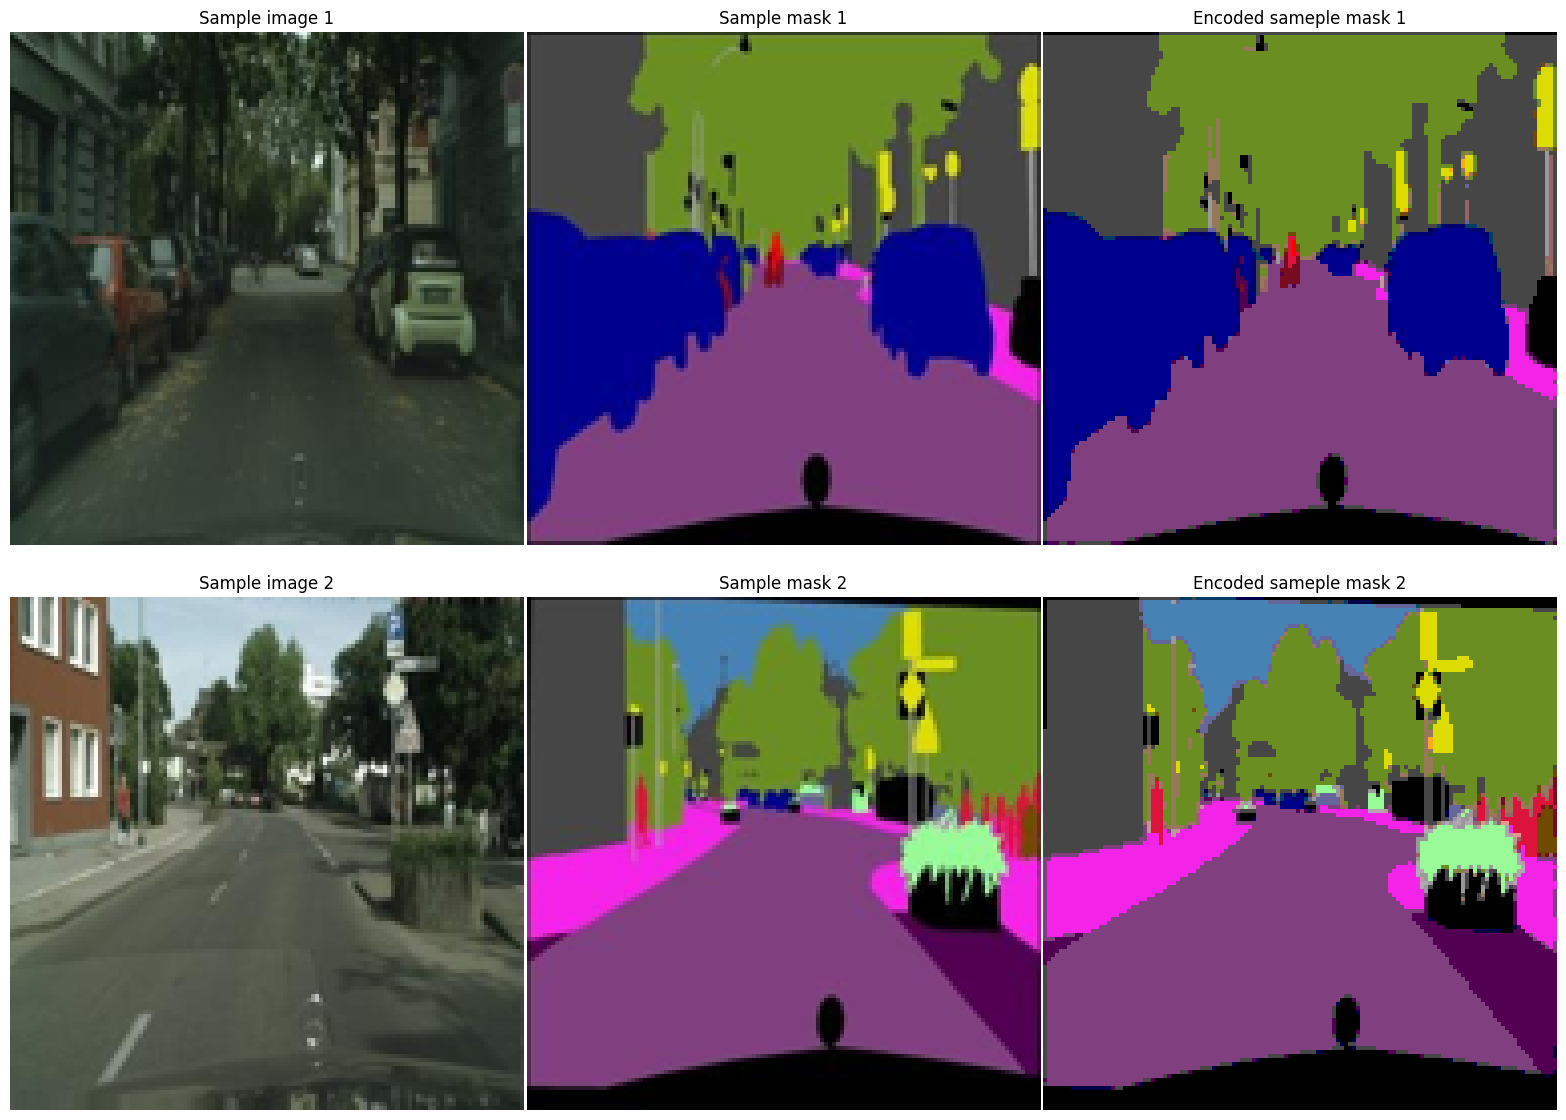

In [9]:
# 훈련 샘플 이미지와 그에 대응하는 마스크 및 인코딩된 마스크를 시각화

plt.figure(figsize=[20, 14])


for i in range(2):
    img = train_images[i]
    msk = train_masks[i]
    enc = train_masks_enc[i]

    tmp = np.zeros([enc.shape[0], enc.shape[1], 3])
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[enc[row, col]]
            tmp = tmp.astype('uint8')

    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Sample image {}'.format(str(i+1)))

    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(msk)
    plt.axis('off')
    plt.gca().set_title('Sample mask {}'.format(str(i+1)))

    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(tmp)
    plt.axis('off')
    plt.gca().set_title('Encoded sameple mask {}'.format(str(i+1)))

plt.subplots_adjust(wspace=0, hspace=0.1)

In [10]:
# 이미지와 마스크를 numpy 배열로 변환하고 데이터 타입을 'float32'로 설정
train_images = np.stack(train_images).astype('float32')
train_masks_enc = np.stack(train_masks_enc).astype('float32')

val_images = np.stack(val_images).astype('float32')
val_masks_enc = np.stack(val_masks_enc).astype('float32')

In [11]:
def conv2d_block(input_tensor, n_filters, kernel_size=3): # Convolutional 레이어와 ReLU 활성화 함수를 연속적으로 적용하는 블록을 생성
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=kernel_size,
                                   kernel_initializer='he_normal', activation='relu', padding='same')(x)
    return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3): # 인코더 블록을 생성하여 feature map을 추출하고, 풀링과 드롭아웃을 적용
    f = conv2d_block(inputs, n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
    p = tf.keras.layers.Dropout(dropout)(p)

    return f, p


def encoder(inputs): # 인코더 부분을 구성하여 여러 레이어를 통해 feature map을 생성하고 축소
    f1, p1 = encoder_block(inputs, n_filters=64)
    f2, p2 = encoder_block(p1, n_filters=128)
    f3, p3 = encoder_block(p2, n_filters=256)
    f4, p4 = encoder_block(p3, n_filters=512)

    return p4, (f1, f2, f3, f4)

def bottleneck(inputs): #네트워크의 병목(bottleneck) 부분을 생성
    bottle_neck = conv2d_block(inputs, n_filters=1024)
    return bottle_neck

# Decoder
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3): # 디코더 블록을 생성하여 업샘플링과 Convolution을 수행
    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides, padding='same')(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters)

    return c

def decoder(inputs, convs, output_channels): #디코더 부분을 구성하여 feature map을 원본 크기로 복원
    f1, f2, f3, f4 = convs

    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=3, strides=2)
    c7 = decoder_block(c6, f3, n_filters=256, kernel_size=3, strides=2)
    c8 = decoder_block(c7, f2, n_filters=128, kernel_size=3, strides=2)
    c9 = decoder_block(c8, f1, n_filters=64, kernel_size=3, strides=2)
    outputs = tf.keras.layers.Conv2D(output_channels, 1, activation='softmax')(c9)

    return outputs

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

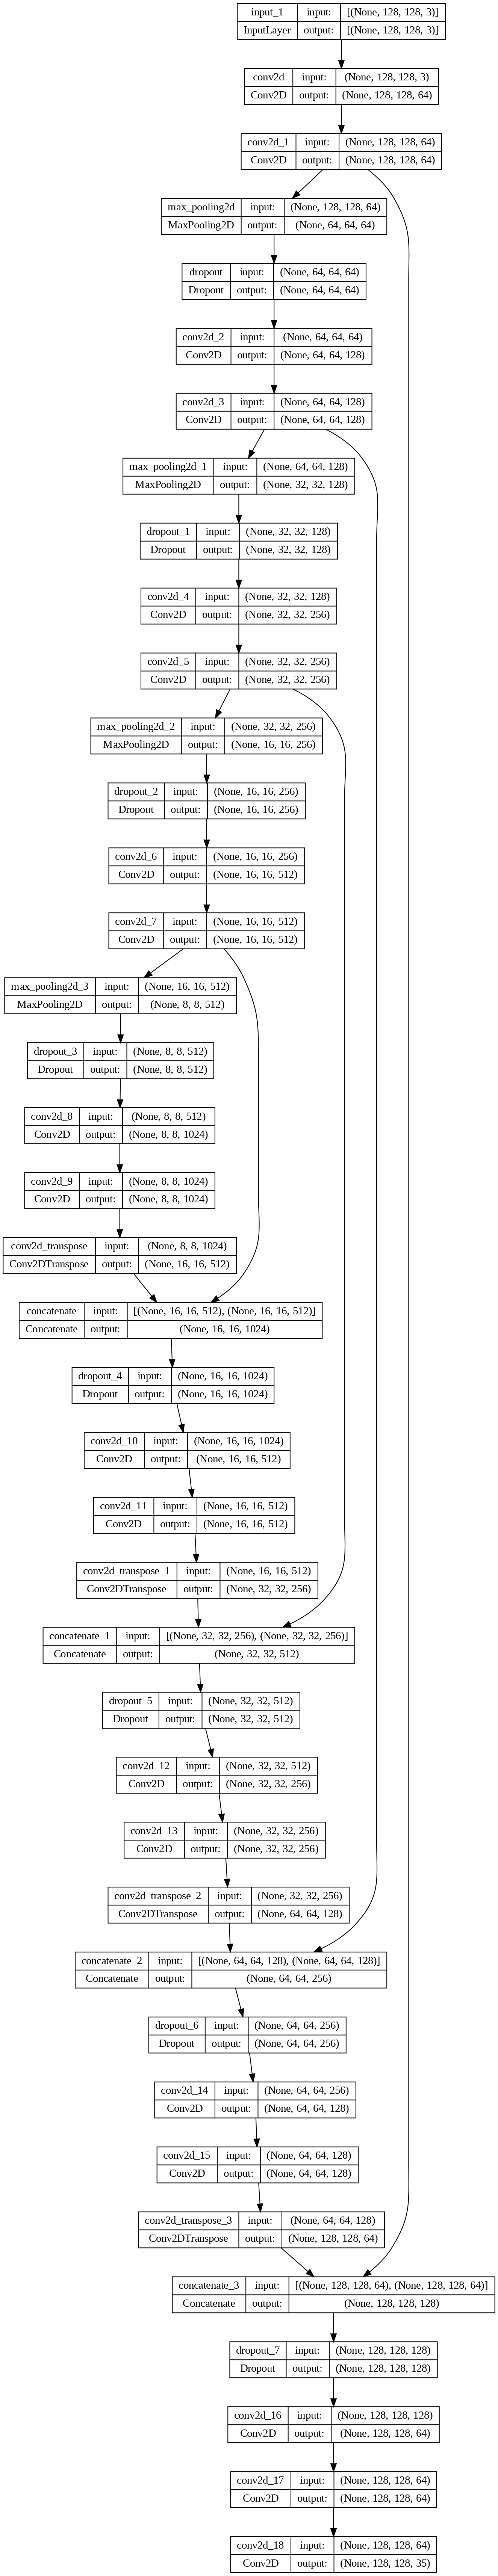

In [12]:
OUTPUT_CHANNELS = N_CLASSES

def UNet(): # Keras 모델 객체를 생성
    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)) #입력 텐서를 정의

    encoder_output, convs = encoder(inputs)
    bottle_neck = bottleneck(encoder_output)
    outputs = decoder(bottle_neck, convs, OUTPUT_CHANNELS)

    model = tf.keras.Model(inputs, outputs)

    return model

model = UNet()
model.summary()

tf.keras.utils.plot_model(model, show_shapes = True,dpi=150) #모델의 구조를 시각화

In [13]:
# 모델 학습 설정과 실행 정의
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])
model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH, monitor='val_loss', save_best_only=True, save_weights_only=True,verbose=1, mode = 'min') #콜백을 설정하여 모델의 가중치를 저장
history = model.fit(x = train_images,
                    y = train_masks_enc,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    validation_data = (val_images, val_masks_enc),
                    callbacks = [model_checkpoint])

Epoch 1/15
186/186 [==============================] - ETA: 0s - loss: 8.7591 - accuracy: 0.3965
Epoch 1: val_loss improved from inf to 1.67712, saving model to ./cityscapes-unet.ckpt
186/186 [==============================] - 100s 400ms/step - loss: 8.7591 - accuracy: 0.3965 - val_loss: 1.6771 - val_accuracy: 0.5622
Epoch 2/15
186/186 [==============================] - ETA: 0s - loss: 1.3223 - accuracy: 0.6472
Epoch 2: val_loss improved from 1.67712 to 1.18402, saving model to ./cityscapes-unet.ckpt
186/186 [==============================] - 54s 292ms/step - loss: 1.3223 - accuracy: 0.6472 - val_loss: 1.1840 - val_accuracy: 0.6772
Epoch 3/15
186/186 [==============================] - ETA: 0s - loss: 1.1154 - accuracy: 0.6991
Epoch 3: val_loss improved from 1.18402 to 1.08853, saving model to ./cityscapes-unet.ckpt
186/186 [==============================] - 54s 292ms/step - loss: 1.1154 - accuracy: 0.6991 - val_loss: 1.0885 - val_accuracy: 0.7094
Epoch 4/15
186/186 [====================

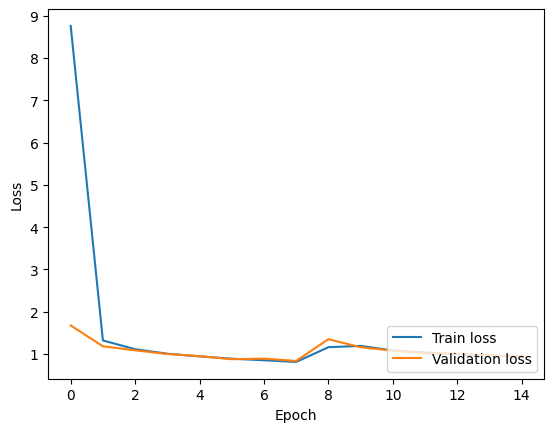

In [14]:
# 모델 시각화
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

1/1 [==============================] - 0s 18ms/step


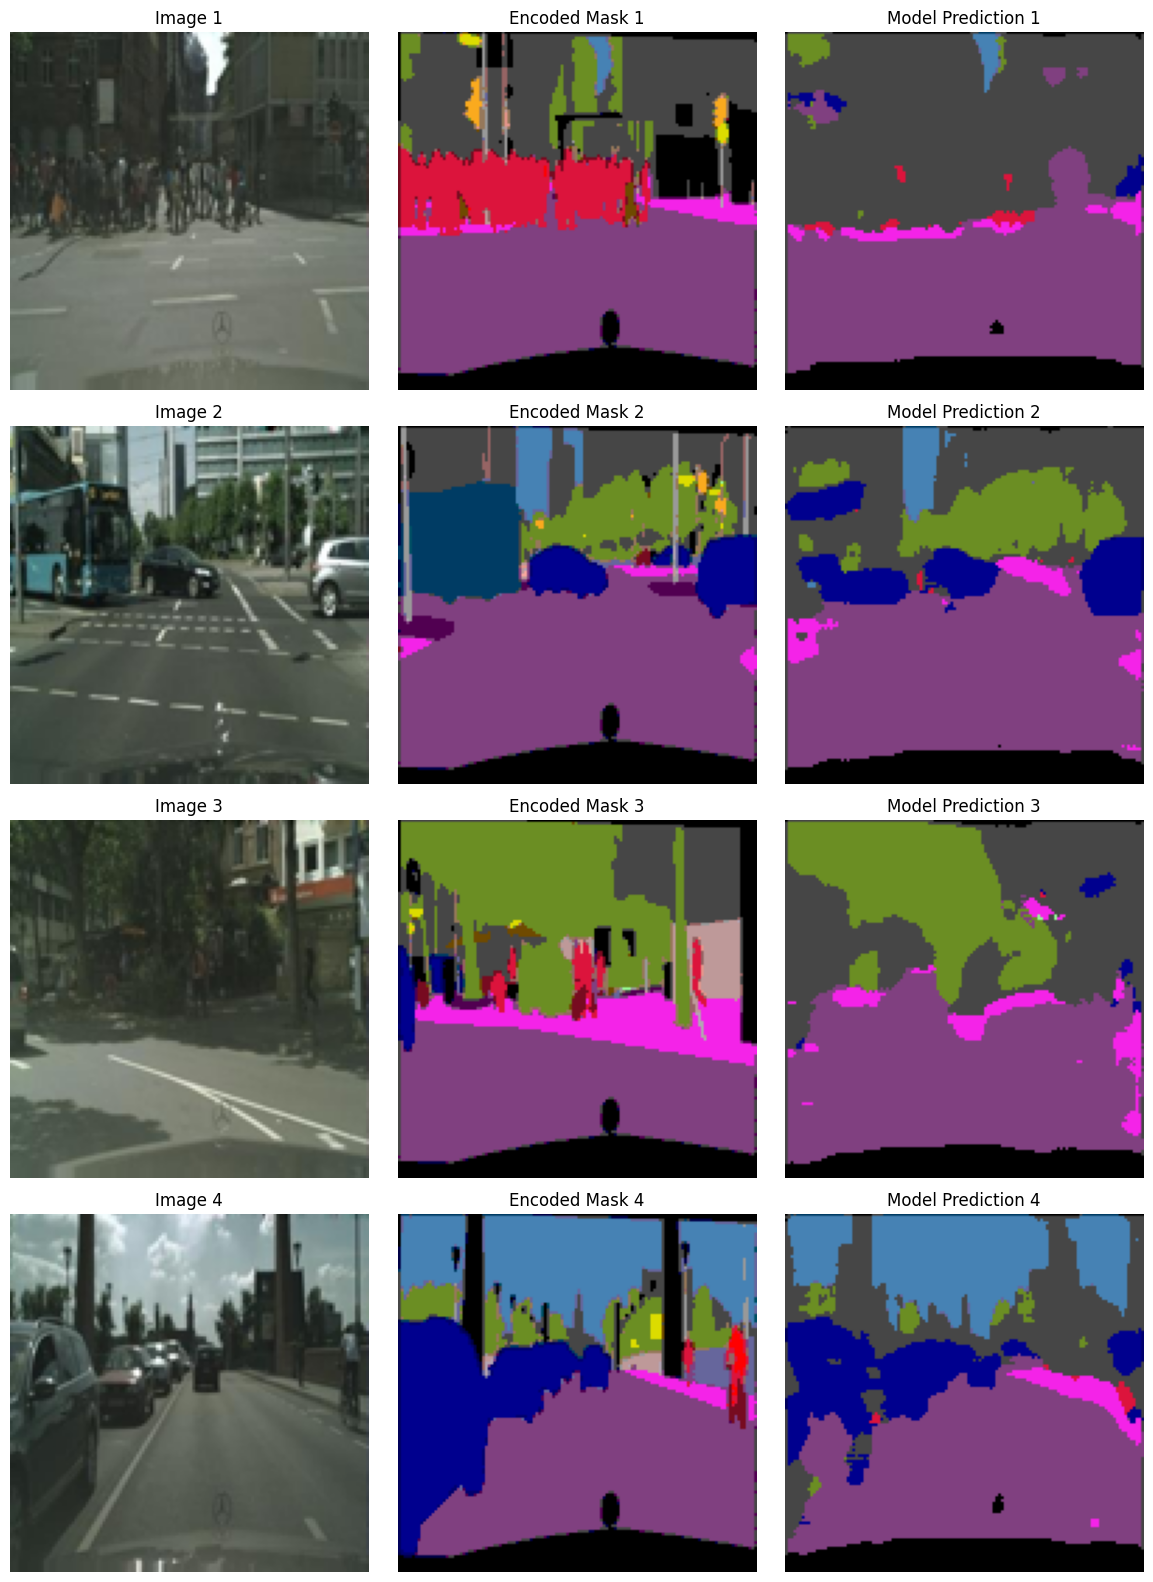

In [15]:
plt.figure(figsize=[15, 20])

for i in range(4):
    img = val_images[i] # i번째 이미지를 가져옵니다.
    enc = val_masks_enc[i] # i번째 이미지에 대한 정답 마스크를 가져옵니다.

    # 이미지를 모델에 전달하여 예측을 생성합니다.
    # reshape 함수를 사용하여 입력을 모델이 예상하는 형태로 만듭니다.
    pred = model.predict(img.reshape([1] + [IMAGE_SIZE, IMAGE_SIZE, 3]))
    # 예측 결과는 각 클래스에 대한 확률을 포함하므로 argmax 함수를 사용하여 가장 높은 확률을 가진 클래스를 선택합니다.
    pred = np.squeeze(np.argmax(pred, axis=-1))

    # 마스크와 예측을 시각화할 빈 이미지를 생성합니다.
    tmp1 = np.zeros([enc.shape[0], enc.shape[1], 3])
    tmp2 = np.zeros([enc.shape[0], enc.shape[1], 3])

    # 각 픽셀에 대해 반복합니다.
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            # 각 픽셀의 레이블에 해당하는 색을 id2color 사전에서 찾아서 임시 이미지에 할당합니다.
            tmp1[row, col, :] = id2color[enc[row, col]]
            tmp1 = tmp1.astype('uint8') # uint8 형식으로 변환합니다.

            tmp2[row, col, :] = id2color[pred[row, col]]
            tmp2 = tmp2.astype('uint8') # uint8 형식으로 변환합니다.

    # 원본 이미지, 마스크, 예측 결과를 그림에 그립니다.
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(i+1)))

    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(tmp1)
    plt.axis('off')
    plt.gca().set_title('Encoded Mask {}'.format(str(i+1)))

    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(tmp2)
    plt.axis('off')
    plt.gca().set_title('Model Prediction {}'.format(str(i+1)))

# subplot 사이의 간격을 조정합니다.
plt.subplots_adjust(wspace=0, hspace=0.1)